# Flower categoriser

In [1]:
# import required libraries
import os
from fastai.vision.all import *
from fastai.vision.widgets import *
from PIL import Image

## Helper functions

In [2]:
def search_images_bing(key, term, min_sz=128, max_images=150):    
     params = {'q':term, 'count':max_images, 'min_height':min_sz, 'min_width':min_sz}
     headers = {"Ocp-Apim-Subscription-Key":key}
     search_url = "https://api.bing.microsoft.com/v7.0/images/search"
     response = requests.get(search_url, headers=headers, params=params)
     response.raise_for_status()
     search_results = response.json()    
     return L(search_results['value'])

## Get image data

### To get the image data, the Bing image search API is used

In [3]:
# setup key for API
key = os.environ.get("AZURE_SEARCH_KEY", "7ecd1c55f4a44a0983e55d160cbf5206")

In [4]:
search_images_bing

<function __main__.search_images_bing(key, term, min_sz=128, max_images=150)>

In [5]:
# search for images of roses
results = search_images_bing(key, 'rose flower')
# each search returns 150 results
ims = results.attrgot('content_url')
len(ims)

150

In [6]:
# make images folder
os.mkdir("images")

FileExistsError: [Errno 17] File exists: 'images'

#### Check download capability

In [7]:
ims = ["http://4.bp.blogspot.com/-xMlNGMpDpdg/UNsDnrvAKYI/AAAAAAAAADo/mhdAW_1xSCg/s1600/rose1.jpg"]

In [8]:
# check that image download works
example_image = ims[0]
destination = "images/rose.jpg"
download_url(example_image, destination)

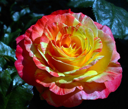

In [9]:
im = Image.open(destination)
im.to_thumb(128, 128)

####  Download images

In [10]:
flower_types = "rose", "gerbera", "tulip", "lily", \
"orchid", "iris", "carnation", "sunflower", "hydrangea", \
"marigold", "lotus","dahlia", "gladioli", "chrysanthemums", \
"camellia", "peony", "lavender", "snapdragon", "hibiscus"
path = Path("images/flowers")

In [11]:
# if the folder doesn't already exist
if not path.exists(): 
    path.mkdir() # create flowers directory
    # for each flower type
    for o in flower_types:
            # set up folder for flower_type
            destination = (path/o)
            destination.mkdir(exist_ok=True) 
            # download images to relevant folder
            results = search_images_bing(key, f"{o} flower")
            download_images(destination, urls=results.attrgot("contentUrl"))
            print(f"{o} flowers have downloaded")

In [12]:
# get list of downloaded file names recursively
fns = get_image_files(path)
fns

(#2642) [Path('images/flowers/camellia/00000000.jpg'),Path('images/flowers/camellia/00000001.jpg'),Path('images/flowers/camellia/00000002.jpg'),Path('images/flowers/camellia/00000003.jpg'),Path('images/flowers/camellia/00000004.jpg'),Path('images/flowers/camellia/00000005.jpg'),Path('images/flowers/camellia/00000006.jpg'),Path('images/flowers/camellia/00000007.jpg'),Path('images/flowers/camellia/00000009.jpg'),Path('images/flowers/camellia/00000010.JPG')...]

In [14]:
# collate failed images
failed = verify_images(fns)
failed

/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 12 bytes but only got 11. Skipping tag 33432
  " Skipping tag %s" % (size, len(data), tag)


(#0) []

In [15]:
# remove invalid images
failed.map(Path.unlink)

(#0) []

## Load image data

### Crate datablock for image data

In [16]:
flowers = DataBlock(
    # outline kind of data we're working with
    blocks=(ImageBlock, CategoryBlock),
    # how to get list of items
    get_items=get_image_files,
    # how to create the validation set
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    # how to label the data
    get_y=parent_label,
    # resize data
    item_tfms=Resize(128))

In [17]:
dls = flowers.dataloaders(path)

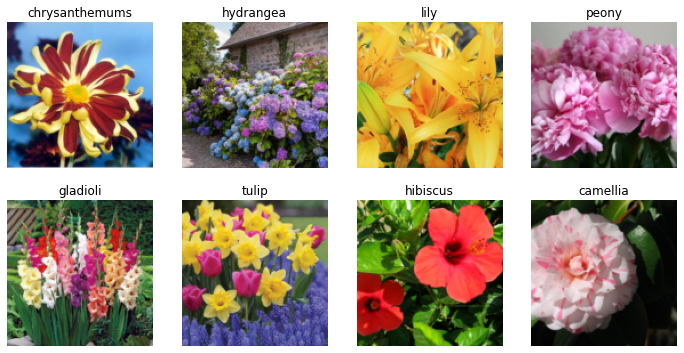

In [18]:
dls.valid.show_batch(max_n=8, nrows=2)

### Augment data

Settings for augmentation:
- crops images randomly using min 50% of image
- resize to 224x224 
- apply the most useful transforms 

In [19]:
# make dataloaders with augmentations 
flowers = flowers.new( 
    item_tfms=RandomResizedCrop(224, min_scale=0.5), 
    batch_tfms=aug_transforms())
dls = flowers.dataloaders(path)

## Train model

Model description:
- CNN model based on resnet18 architecture
- Base pretrained model is adjusted with transfer learning

In [20]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.923599,1.048103,0.310606,00:27


/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 12 bytes but only got 11. Skipping tag 33432
  " Skipping tag %s" % (size, len(data), tag)
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.p

epoch,train_loss,valid_loss,error_rate,time
0,1.119986,0.876620,0.255682,00:27
1,0.902923,0.766856,0.225379,00:28
2,0.720477,0.687052,0.196970,00:27
3,0.546379,0.648011,0.183712,00:26
4,0.416392,0.658678,0.162879,00:27
5,0.302627,0.619456,0.164773,00:27
6,0.237548,0.613868,0.160985,00:26
7,0.204033,0.604148,0.155303,00:28


/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 12 bytes but only got 11. Skipping tag 33432
  " Skipping tag %s" % (size, len(data), tag)
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.p

### Investigate training results

Confusion matrix

/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


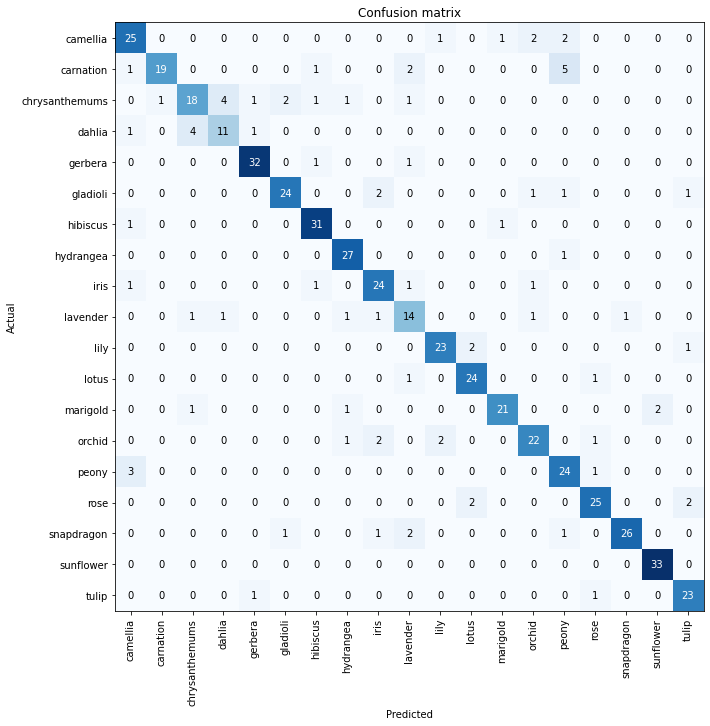

In [21]:
# confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10))

What are our top losses?

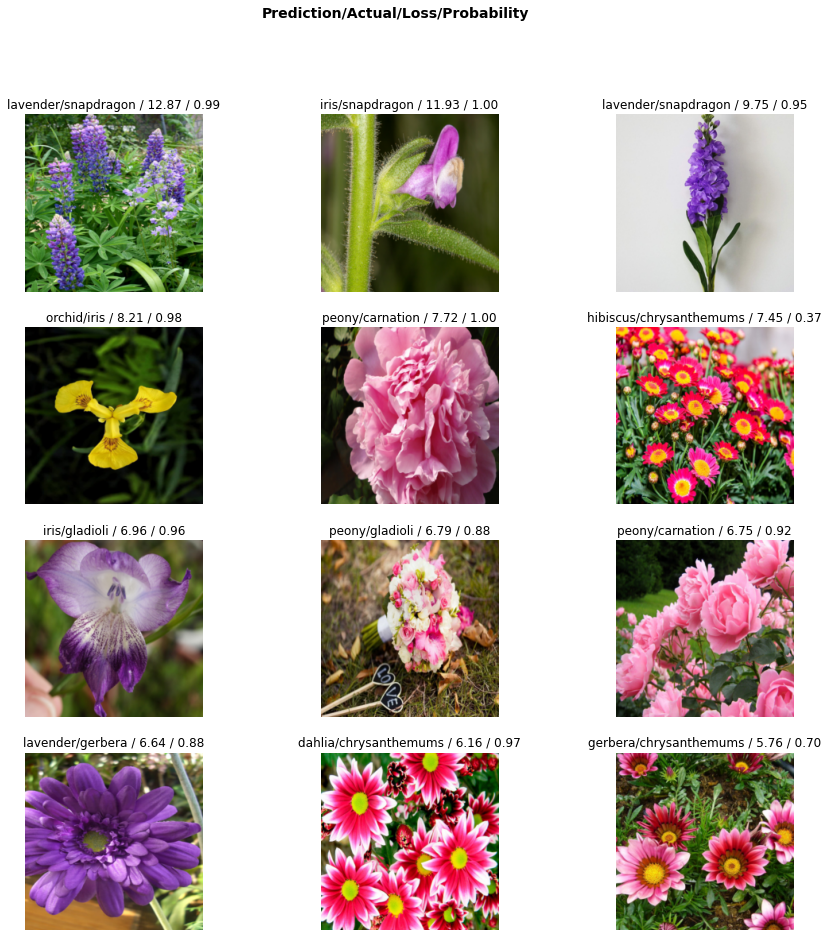

In [25]:
interp.plot_top_losses(12, nrows=4, figsize=(15,15))

Clean our dataset 

In [26]:
print("Current number of examples in our dataset:", len(fns))

Current number of examples in our dataset: 2642


In [ ]:
# invoke cleaner gui
cleaner = ImageClassifierCleaner(learn)
cleaner

/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 12 bytes but only got 11. Skipping tag 33432
  " Skipping tag %s" % (size, len(data), tag)


/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [35]:
# delete (unlink images marked for deletion)
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [ ]:
# perform label change for selected classes
for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [36]:
print("Current number of examples in our dataset:", len(fns))

Current number of examples in our dataset: 2643


## Export model

In [50]:
# save model 
learn.export()

In [51]:
# check model has been saved
path = Path()
path.ls(file_exts=".pkl")

(#1) [Path('export.pkl')]